In [69]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import mnist
import matplotlib.pyplot as plt

In [191]:
class FlowBijector(torch.nn.Module):
    def __init__(self, keep = 0, change = 1):
        super().__init__()
        self.keep = keep
        self.change = change
        self.t_net = torch.nn.Sequential(
            torch.nn.Linear(1,100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,1)
        )
        self.s_net = torch.nn.Sequential(
            torch.nn.Linear(1,100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,1)
        )

    def forward(self,inputs):
        outputs = torch.zeros_like(inputs)
        
        t_vals = self.t_net(inputs[:,self.keep].reshape(-1,1))[:,0]
        s_vals = self.s_net(inputs[:,self.keep].reshape(-1,1))[:,0]
        
        outputs[:,self.keep] = inputs[:,self.keep]
        outputs[:,self.change] = inputs[:,self.change] * torch.exp(s_vals) + t_vals
        return outputs

    def reverse(self,outputs):
        inputs = torch.zeros_like(outputs)
        
        t_vals = self.t_net(outputs[:,self.keep].reshape(-1,1))[:,0]
        s_vals = self.s_net(outputs[:,self.keep].reshape(-1,1))[:,0]
        
        inputs[:,self.keep] = outputs[:,self.keep]
        inputs[:,self.change] = (outputs[:,self.change] -  t_vals )*torch.exp(-s_vals)
        
        return inputs,s_vals
    
class Flow(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bijectors = torch.nn.ModuleList([
            FlowBijector(0,1),FlowBijector(1,0),   
            FlowBijector(0,1),FlowBijector(1,0),   
            FlowBijector(0,1),FlowBijector(1,0),   
            FlowBijector(0,1),FlowBijector(1,0),   
            FlowBijector(0,1),FlowBijector(1,0),   
            FlowBijector(0,1),FlowBijector(1,0),   
            FlowBijector(0,1),FlowBijector(1,0),   
            FlowBijector(0,1),FlowBijector(1,0),   
        ])

    def forward(self,samples):
        for bij in self.bijectors:
            samples = bij.forward(samples)
        return samples

    def reverse(self,samples):
        logJ = 0
        for bij in reversed(self.bijectors):
            samples,this_logJ = bij.reverse(samples)
            logJ += this_logJ
        return samples, logJ

torch.Size([123])


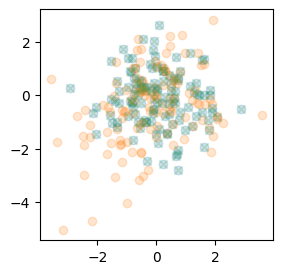

In [192]:
with torch.no_grad():
    flow = Flow()
    inputs = torch.randn(123,2)
    outputs = flow.forward(inputs)
    rev,logJ = flow.reverse(outputs)
    print(logJ.shape)
    plt.scatter(inputs[:,0],inputs[:,1], alpha = 0.2)
    plt.scatter(outputs[:,0],outputs[:,1], alpha = 0.2)
    plt.scatter(rev[:,0],rev[:,1], alpha = 0.2, marker = 'x')
    plt.gcf().set_size_inches(3,3)

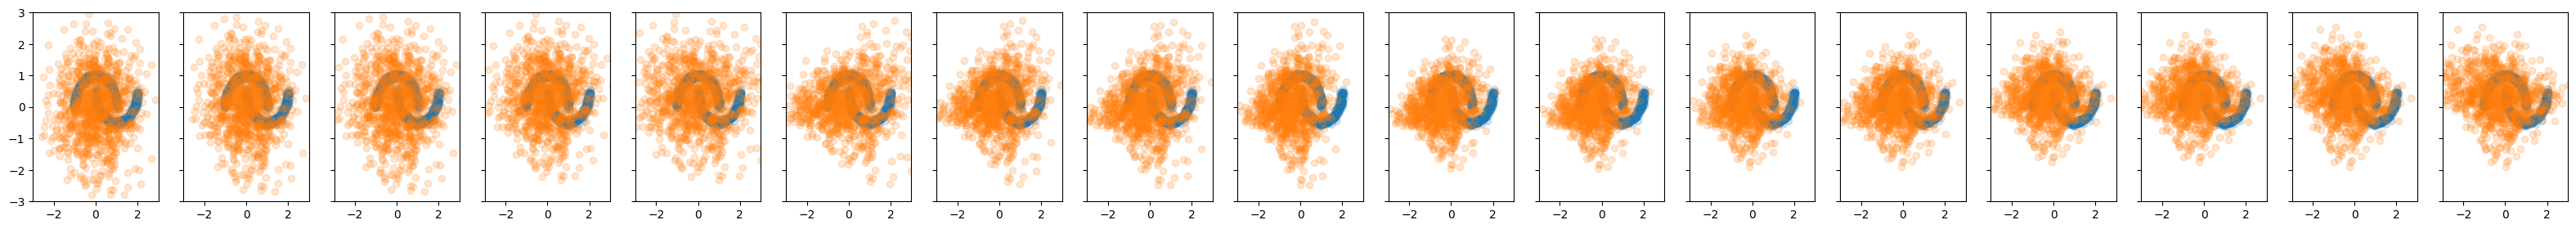

tensor(3.1133, grad_fn=<NegBackward0>)


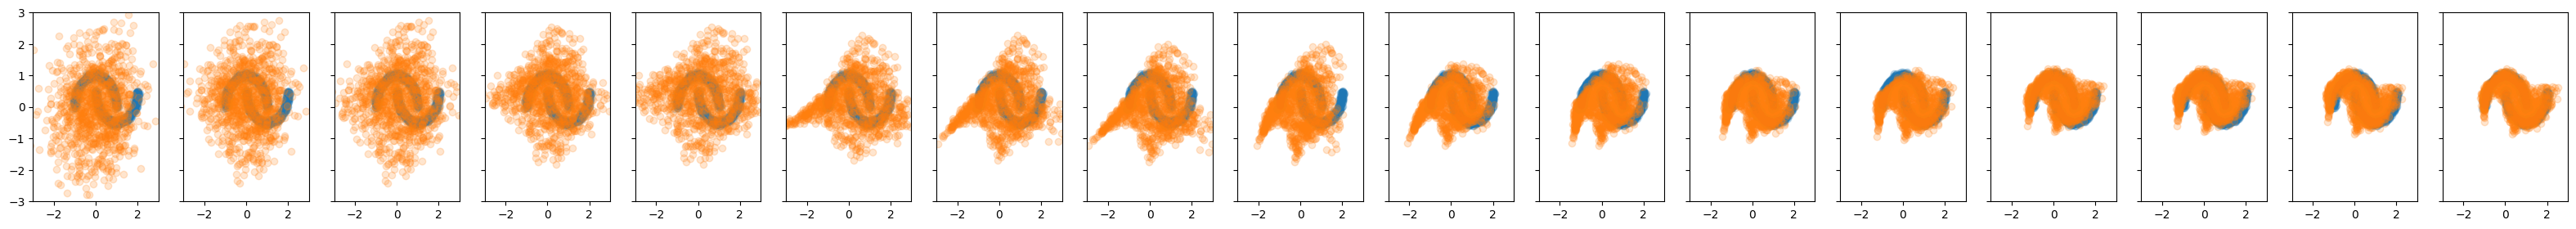

tensor(1.3445, grad_fn=<NegBackward0>)


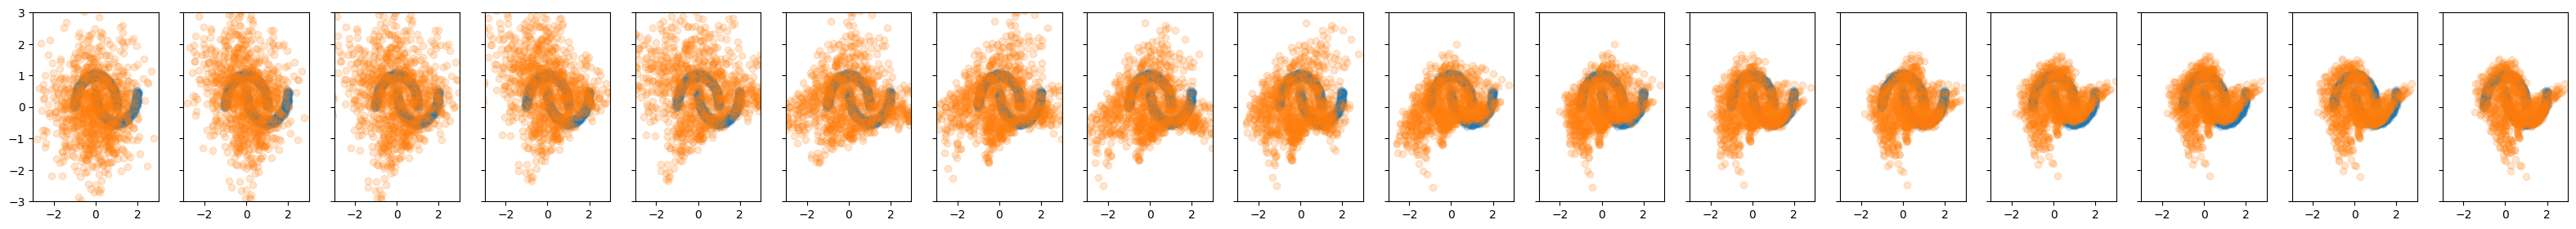

tensor(1.6305, grad_fn=<NegBackward0>)


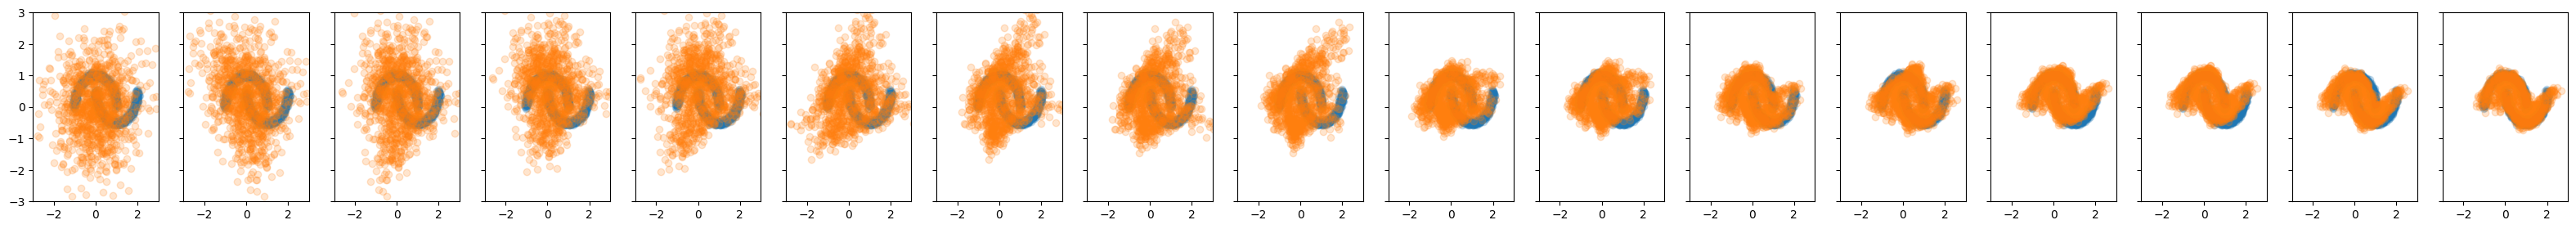

tensor(1.0792, grad_fn=<NegBackward0>)


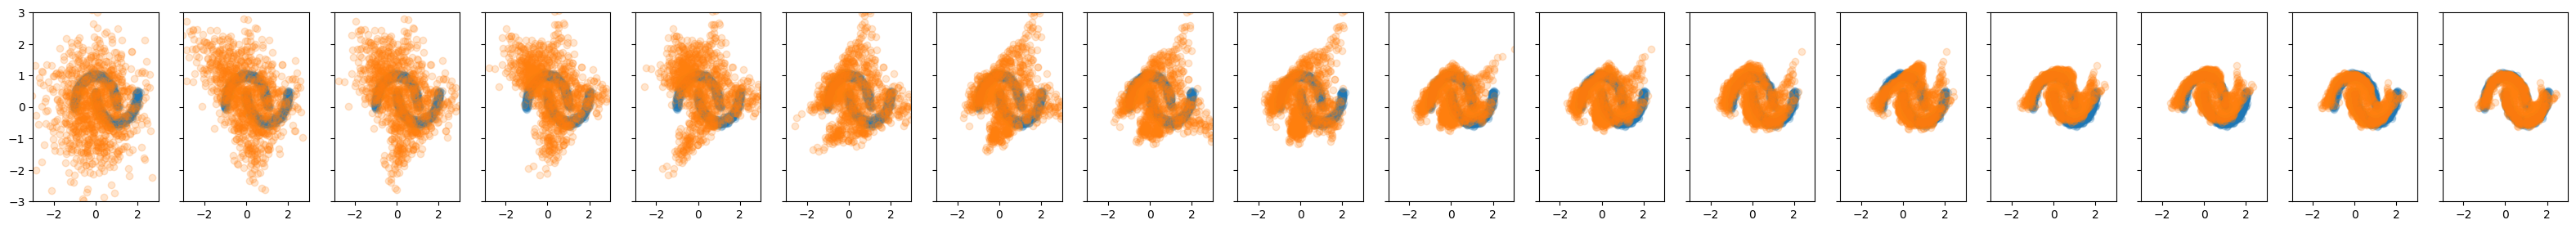

tensor(0.8022, grad_fn=<NegBackward0>)


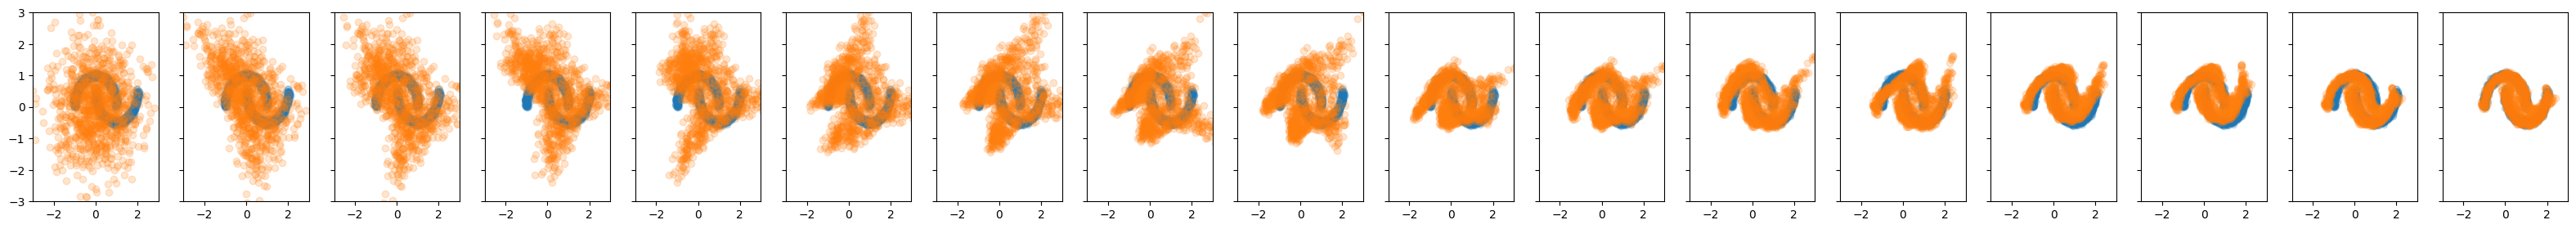

tensor(0.5961, grad_fn=<NegBackward0>)


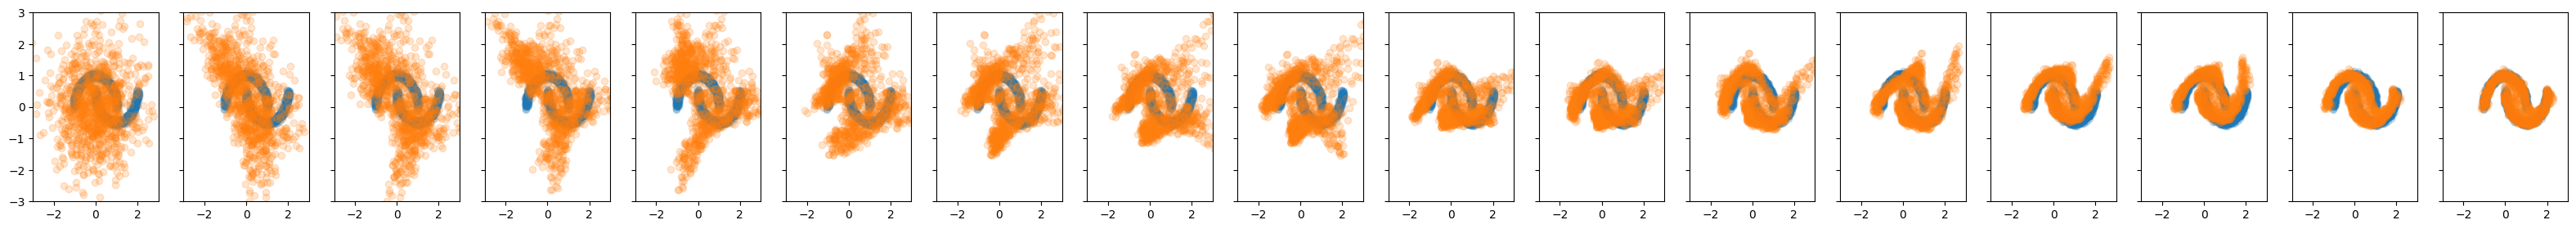

tensor(0.5377, grad_fn=<NegBackward0>)


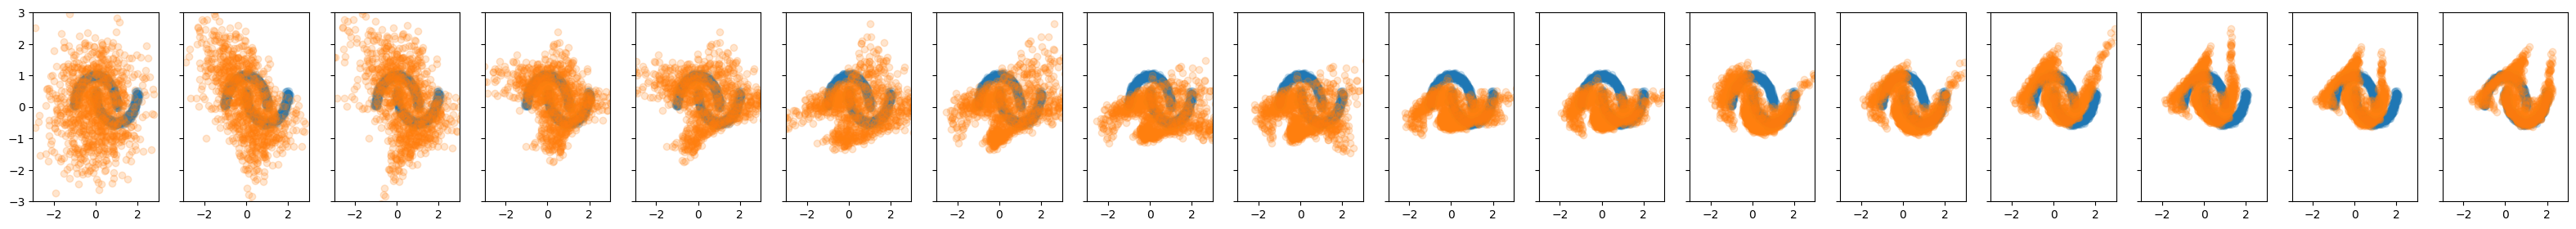

tensor(1.1306, grad_fn=<NegBackward0>)


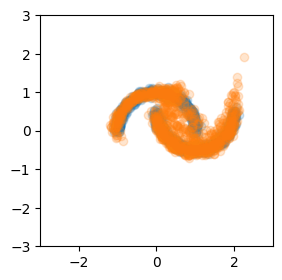

In [205]:
def plot_flow_progression(target,flow):
    samples = torch.randn(1000,2)
    f,axarr = plt.subplots(1,len(flow.bijectors)+1, sharex = True, sharey = True)
    axarr[0].scatter(target[:,0],target[:,1], alpha = 0.2)
    axarr[0].scatter(samples[:,0],samples[:,1], alpha = 0.2)
    axarr[0].set_xlim(-3,3)
    axarr[0].set_ylim(-3,3)
    with torch.no_grad():
        for i,bij in enumerate(flow.bijectors):
            samples = bij.forward(samples)
            axarr[i+1].scatter(target[:,0],target[:,1], alpha = 0.2)
            axarr[i+1].scatter(samples[:,0],samples[:,1], alpha = 0.2)
            axarr[i+1].set_xlim(-3,3)
            axarr[i+1].set_ylim(-3,3)

def plot_flow(target,flow):
    samples = torch.randn(1000,2)
    samples = flow.forward(samples)
    with torch.no_grad():
        plt.scatter(target[:,0],target[:,1], alpha = 0.2)
        plt.scatter(samples[:,0],samples[:,1], alpha = 0.2)
        plt.xlim(-3,3)
        plt.ylim(-3,3)

            
def train_flow():
    flow = Flow()
    opt = torch.optim.Adam(flow.parameters(),lr = 5e-4)
    latent_dist = torch.distributions.Normal(0,1)
    for i in range(200):
        target,_ = sklearn.datasets.make_moons(1000, noise = 0.05)
        target = torch.FloatTensor(target)
        latent, logJ = flow.reverse(target)
        log_prob = latent_dist.log_prob(latent).sum(axis=-1) - logJ
        loss = -log_prob.mean()
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i % 25 == 0:
            plot_flow_progression(target,flow)
            plt.gcf().set_size_inches(40,3)
            plt.show()
            print(loss)
    plot_flow(target,flow)
    plt.gcf().set_size_inches(3,3)
train_flow()